In [1]:
from IPython.core.display import HTML
with open('../style.css') as f:
    css = f.read()
HTML(css)

# A Backtracking Solver for CSPs

## Utility Functions

The module `extractVariables` implements the function $\texttt{extractVars}(e)$ that takes a *Python* expression $e$ as its argument and returns the set of all variables and function names occurring in $e$.

In [2]:
import extractVariables as ev

In [3]:
ev.extractVars('abs(x - y) + abs(z1 - z2)')

{'abs', 'x', 'y', 'z1', 'z2'}

Below, `dir(__builtins__)` returns a list containing all predefined variables, functions, and classes. 

In [4]:
dir(__builtins__)

['ArithmeticError',
 'AssertionError',
 'AttributeError',
 'BaseException',
 'BlockingIOError',
 'BrokenPipeError',
 'BufferError',
 'BytesWarning',
 'ChildProcessError',
 'ConnectionAbortedError',
 'ConnectionError',
 'ConnectionRefusedError',
 'ConnectionResetError',
 'DeprecationWarning',
 'EOFError',
 'Ellipsis',
 'EnvironmentError',
 'Exception',
 'False',
 'FileExistsError',
 'FileNotFoundError',
 'FloatingPointError',
 'FutureWarning',
 'GeneratorExit',
 'IOError',
 'ImportError',
 'ImportWarning',
 'IndentationError',
 'IndexError',
 'InterruptedError',
 'IsADirectoryError',
 'KeyError',
 'KeyboardInterrupt',
 'LookupError',
 'MemoryError',
 'ModuleNotFoundError',
 'NameError',
 'None',
 'NotADirectoryError',
 'NotImplemented',
 'NotImplementedError',
 'OSError',
 'OverflowError',
 'PendingDeprecationWarning',
 'PermissionError',
 'ProcessLookupError',
 'RecursionError',
 'ReferenceError',
 'ResourceWarning',
 'RuntimeError',
 'RuntimeWarning',
 'StopAsyncIteration',
 'StopIter

The function `collect_variables(expr)` takes a string `expr` that can be interpreted as a Python expression as input and collects all variables occurring in `expr`.  It takes care to remove the function symbols from the names returned by `extract_variables`.

In [5]:
def collect_variables(expr):
    return frozenset(var for var in ev.extractVars(expr)
                         if  var not in dir(__builtins__)
                         if  var not in ['and', 'or', 'not']
                    )

In [6]:
collect_variables('abs(x - y) + abs(z1 - z2)')

frozenset({'x', 'y', 'z1', 'z2'})

The function `arb(S)` takes a set `S` as input and returns an arbitrary element from 
this set.

In [7]:
def arb(S):
    "Return some element from the set S."
    for x in S:
        return x

Backtracking is simulated by raising the `Backtrack` exception.  We define this new class of exceptions so that we can distinguish `Backtrack` exceptions from ordinary exceptions.  This is done by creating a new, empty class that is derived from the class `Exception`.  

In [8]:
class Backtrack(Exception):
    pass

## The Backtracking Solver

The procedure `solve(P)` takes a a *constraint satisfaction problem* 
`P` as input.  Here `P` is a triple of the form 
$$ \mathcal{P} = \langle \mathtt{Variables}, \mathtt{Values}, \mathtt{Constraints} \rangle $$
where 
- `Variables` is a set of strings which serve as *variables*,
- `Values` is a set of *values* that can be assigned 
  to the variables in the set `Variables`.
- `Constraints` is a set of formulas from first order logic.  
  Each of these formulas is  called a *constraint* of $\mathcal{P}$.
  
The main purpose of the function `solve` is to convert the CSP `P` into an 
*augmented CSP* where every constraint $f$ is annotated with
the variables ocurring in $f$.  This annotates CSP is then solved using the function
`backtrack_search`.

In [9]:
def solve(P):
    Variables, Values, Constraints = P
    csp = (Variables, Values, [(f, collect_variables(f)) for f in Constraints])
    try:
        return backtrack_search({}, csp)
    except Backtrack:
        return None

The function `backtrack_search` takes two arguments:
- `Assignment` is a partial variable assignment that is represented as a dictionary.  Initially, this assignment will be the  empty dictionary.  Every recursive call of `backtrack_search` adds the assignment of one variable to  the given assignment.  `Assignment` is *consistent*, i.e. all constraints $f$ that contain only variables from the set $\mathtt{dom}(A)$ are satisfied.
- `P` is an *augmented constraint satisfaction problem*, 
   i.e. `P` is a tripple of the form 
   $$ \mathcal{P} = \langle \mathtt{Vars}, \mathtt{Values}, \mathtt{Constraints} \rangle $$
    where 
    - $\mathtt{Vars}$ is a set of strings which serve as *variables*,
    - $\mathtt{Values}$ is a set of *values* that can be assigned 
      to the variables in $\mathtt{Vars}$.
    - $\mathtt{Constraints}$ is a set of pairs of the form $(f, V)$ where $f$ is a Boolean Python 
      expression, while $V$ is the set of variables occuring in $f$.
The function `backtrack_search` tries to find a solution of `P` by recursively augmenting `Assignment`.

In [10]:
def backtrack_search(Assignment, P):
    Variables, Values, Constraints = P
    if len(Assignment) == len(Variables):
        return Assignment
    var = arb(Variables - Assignment.keys())
    for value in Values:
        try:
            if is_consistent(var, value, Assignment, Constraints):
                NewAss = Assignment.copy()
                NewAss[var] = value
                return backtrack_search(NewAss, P)
        except Backtrack:
            continue
    raise Backtrack()  

The function $\texttt{is_consistent}(\texttt{var}, \texttt{value}, \texttt{Assignment}, \texttt{csp})$ takes four arguments:
- `var` is a variable that does not occur in $\texttt{Assignment}$,
- `value` is a value that can be substituted for this variable,
- `Assignment` is a *consistent* partial variable assignment. 
- `csp` is an *augmented* constraint satisfaction problem.

This function returns `True` iff the partial variable assignment 
$$\texttt{Assignment} \cup \bigl\{\langle\texttt{var} \mapsto\texttt{value}\rangle\bigr\}$$
is consistent with all the constraints occurring in `Constraints`.

In [11]:
def is_consistent(var, value, Assignment, Constraints):
    NewAssign      = Assignment.copy()
    NewAssign[var] = value
    return all(eval(f, NewAssign) for (f, Vs) in Constraints
                                  if  var in Vs and Vs <= NewAssign.keys()
              )

## Solving the Eight-Queens-Puzzle

In [12]:
%run N-Queens-Problem-CSP.ipynb

Variables:   {'V4', 'V1', 'V2', 'V3'}
Values:      {1, 2, 3, 4}
Constraints:
             abs(V4 - V3) != 1
             V1 != V3
             abs(V2 - V1) != 1
             V1 != V2
             abs(V3 - V1) != 2
             abs(V4 - V1) != 3
             abs(V4 - V2) != 2
             abs(V3 - V2) != 1
             V1 != V4
             V2 != V3
             V3 != V4
             V2 != V4


In [13]:
P = create_csp(8)

Backtracking search takes about 22 milliseconds on my desktop to solve the eight queens puzzle.

In [14]:
%%time
Solution = solve(P)
print(f'Solution = {Solution}')

Solution = {'V3': 1, 'V7': 2, 'V1': 6, 'V5': 5, 'V4': 7, 'V8': 4, 'V6': 8, 'V2': 3}
CPU times: user 29.3 ms, sys: 2.65 ms, total: 32 ms
Wall time: 35.4 ms


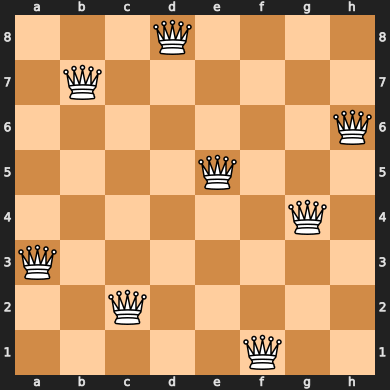

In [15]:
show_solution(Solution)

Backtracking is able to solve the $16$ queens problem in less than a second.

In [ ]:
P = create_csp(16)

In [ ]:
%%time
Solution = solve(P)
print(f'Solution = {Solution}')

## Solving the *Zebra Puzzle*

In [16]:
%run Zebra.ipynb

In [17]:
zebra = zebra_csp()

Backtracking takes about 11 seconds to solve the [Zebra Puzzle](https://en.wikipedia.org/wiki/Zebra_Puzzle).
We develop a better algorithm soon.

In [18]:
%%timeit -n 1 -r 100
Solution = solve(zebra)

4.44 s ± 136 ms per loop (mean ± std. dev. of 100 runs, 1 loop each)


In [ ]:
%%time
Solution = solve(zebra)

In [ ]:
show_solution(Solution)